In [1]:
import matplotlib.pyplot as plt
import numpy
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [2]:
# hyperparams
inp_dim = 28 * 28
#try to use other model params. check overfitting with large models
hidden = 256
out_dim = 32
device_id = 0
device = 'cpu' if device_id == -1 else f'cuda:{device_id}'
n_epochs = 8
batch_size = 128

In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5), (0.5)),
     ])


dataset_train = datasets.MNIST('.', 
                               train=True,            
                               download=True, 
                               transform=transform)
trainloader = torch.utils.data.DataLoader(dataset_train, 
                                          batch_size=batch_size,
                                          shuffle=True, 
                                          num_workers=2, 
                                          drop_last = True,)

dataset_test = datasets.MNIST('.', 
                              train=False,
                              download=True, 
                              transform=transform)
testloader = torch.utils.data.DataLoader(dataset_train, 
                                          batch_size=batch_size,
                                          shuffle=True, 
                                          num_workers=2, 
                                          drop_last = True,)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [5]:
class Encoder(nn.Module):
  #28*28 -> hidden -> hidden_out
  def __init__(self, input_dim, hidden_dim, out_dim):
    super().__init__()
    #TODO try to use other layers
    self.linear1 = nn.Linear(input_dim, hidden_dim)
    self.do = nn.Dropout(0.3)
    self.activ = nn.ReLU()
    self.linear2 = nn.Linear(hidden_dim, hidden_dim)
    self.linear3 = nn.Linear(hidden_dim, out_dim)
    

  def forward(self, x):
    x = self.activ(self.do(self.linear1(x)))
    x = self.activ(self.do(self.linear2(x)))

    return self.linear3(x)

class Decoder(nn.Module):
  #hidden_out-> hidden -> 28*28 
  def __init__(self, input_dim, hidden_dim, out_dim):
    super().__init__()
    #TODO try to use other layers
    self.linear1 = nn.Linear(input_dim, hidden_dim)
    self.do = nn.Dropout(0.3)
    self.activ = nn.ReLU()
    self.linear2 = nn.Linear(hidden_dim, hidden_dim)
    self.linear3 = nn.Linear(hidden_dim, out_dim)

  def forward(self, x):
    x = self.activ(self.do(self.linear1(x)))
    x = self.activ(self.do(self.linear2(x)))

    return self.linear3(x)

class LinearAutoEncoder(nn.Module):
  def __init__(self, input_dim, hidden_dim, out_dim):
    super().__init__()
    self.encoder = Encoder(input_dim, hidden_dim, out_dim)
    self.decoder = Decoder(out_dim, hidden_dim, input_dim)

  def forward(self, x):
    hidden = self.encoder(x)
    x_ = self.decoder(hidden)

    return x_


In [6]:
model = LinearAutoEncoder(inp_dim, hidden, out_dim).to(device)
optim = torch.optim.Adam(model.parameters())
loss_func = nn.L1Loss() #TODO try to use MAE


epoch: 0, step: 0, loss: 0.9449120759963989
epoch: 0, step: 200, loss: 0.28725665807724
epoch: 0, step: 400, loss: 0.26744744181632996


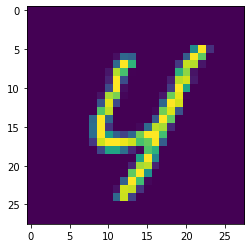

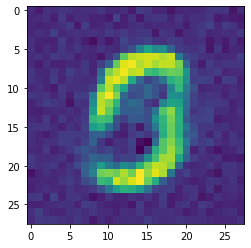

epoch: 1, step: 0, loss: 0.2592407166957855
epoch: 1, step: 200, loss: 0.2478470653295517
epoch: 1, step: 400, loss: 0.23494364321231842


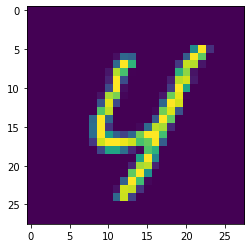

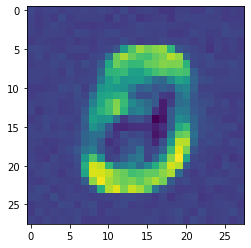

epoch: 2, step: 0, loss: 0.23213545978069305
epoch: 2, step: 200, loss: 0.23420099914073944
epoch: 2, step: 400, loss: 0.2254134863615036


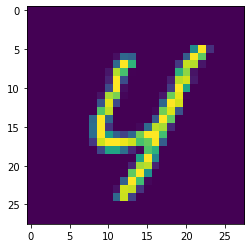

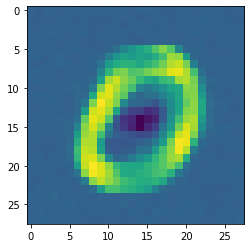

epoch: 3, step: 0, loss: 0.22526006400585175
epoch: 3, step: 200, loss: 0.22438882291316986
epoch: 3, step: 400, loss: 0.2138928771018982


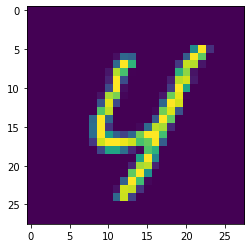

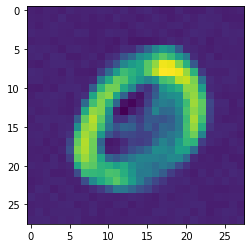

epoch: 4, step: 0, loss: 0.22721675038337708
epoch: 4, step: 200, loss: 0.21124835312366486
epoch: 4, step: 400, loss: 0.22266702353954315


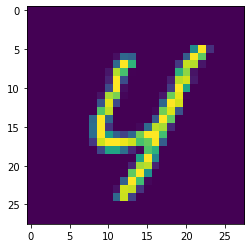

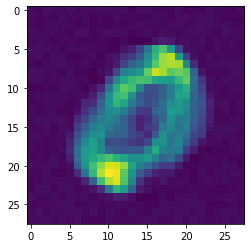

epoch: 5, step: 0, loss: 0.21577538549900055
epoch: 5, step: 200, loss: 0.20326100289821625
epoch: 5, step: 400, loss: 0.2152676284313202


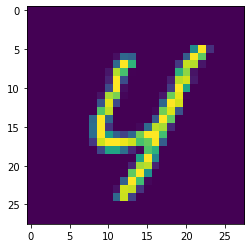

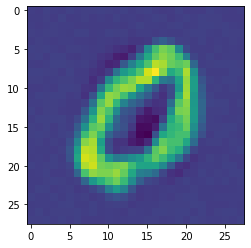

epoch: 6, step: 0, loss: 0.20514947175979614
epoch: 6, step: 200, loss: 0.20372924208641052
epoch: 6, step: 400, loss: 0.1965029090642929


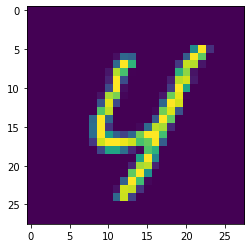

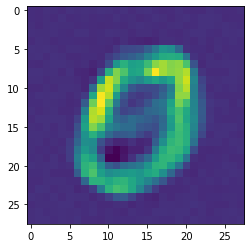

epoch: 7, step: 0, loss: 0.1975574791431427
epoch: 7, step: 200, loss: 0.189263716340065
epoch: 7, step: 400, loss: 0.201312854886055


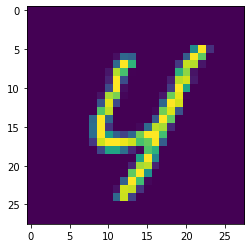

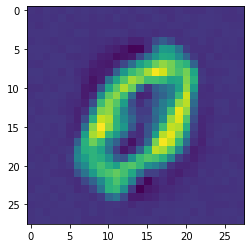

In [7]:
# hidden_out = 40
for epoch in range(n_epochs):
    for i, batch in enumerate(trainloader):
        inputs, labels = batch
        optim.zero_grad()
        target = inputs.view(inputs.size(0), -1).to(device)
        predict = model(target)
        loss = loss_func(target, predict)
        loss.backward()
        optim.step()
        if i % 200 == 0:
            print(f'epoch: {epoch}, step: {i}, loss: {loss.item()}')
    item = dataset_test.data[555].unsqueeze(0).view(1, -1).to(device).float()
    plt.imshow(dataset_test.data[555].detach().numpy())
    plt.show()
    plt.imshow(model(item).view((28, 28)).cpu().detach().numpy())
    plt.show()
    torch.save(model.state_dict(), f'./lin_ae_chkpt_{epoch}.pth')


In [4]:
input_channels = 1
hidden_channels = 256

In [9]:
class ConvEncoder(nn.Module):
  def __init__(self, input_ch, hidden_ch):
    super().__init__()
    #TODO try to use other layers
    self.conv1 = nn.Conv2d(input_ch, hidden_ch, kernel_size=4, stride=1, 
                           padding=2)
    self.do1 = nn.Dropout(0.1)
    self.pool1 = nn.MaxPool2d((4, 4)) 

    self.conv2 = nn.Conv2d(hidden_ch, hidden_ch, kernel_size=3, stride=1, 
                           padding=1)
    self.do2 = nn.Dropout(0.1)
    self.pool2 = nn.MaxPool2d(3, 3) 
    
    self.conv3 = nn.Conv2d(hidden_ch, hidden_ch, kernel_size=2, stride=1, 
                           padding=1)
    self.do3 = nn.Dropout(0.3)
    self.pool3 = nn.MaxPool2d(2, 2) 

    self.conv4 = nn.Conv2d(hidden_ch, 1, kernel_size=2, stride=1, 
                           padding=1)
    self.activ = nn.ReLU()

  def forward(self, x):
    x = self.pool1(self.do1(self.activ(self.conv1(x))))
    x = self.pool2(self.do2(self.activ(self.conv2(x))))
    x = self.pool3(self.do3(self.activ(self.conv3(x))))

    return self.conv4(x)

class ConvDecoder(nn.Module):

  def __init__(self, input_ch, hidden_ch, ):
    super().__init__()
    #TODO try to use other layers
    self.conv1 = nn.Conv2d(1, hidden_ch, kernel_size=2, stride=1, 
                           padding=1)
    self.do1 = nn.Dropout(0.3)
    self.upsample1 = nn.UpsamplingNearest2d(scale_factor=2) 

    self.conv2 = nn.Conv2d(hidden_ch, hidden_ch, kernel_size=2, stride=1, 
                           padding=1)
    self.do2 = nn.Dropout(0.1)
    self.upsample2 = nn.UpsamplingNearest2d(scale_factor=2)
    self.conv3 = nn.Conv2d(hidden_ch, hidden_ch, kernel_size=3, stride=1, 
                           padding=1)
    self.do3 = nn.Dropout(0.1)
    self.upsample3 = nn.UpsamplingNearest2d(scale_factor=2) 
    self.conv4 = nn.Conv2d(hidden_ch, input_ch, kernel_size=3, stride=1, 
                           padding=1)
    self.activ = nn.ReLU()

  def forward(self, x):
    x = self.upsample1(self.do1(self.activ(self.conv1(x))))
    x = self.upsample2(self.do2(self.activ(self.conv2(x))))
    x = self.upsample3(self.do3(self.activ(self.conv3(x))))
    return self.conv4(x)

class ConvAutoEncoder(nn.Module):
  def __init__(self, input_ch, hidden_ch, ):
    super().__init__()
    self.encoder = ConvEncoder(input_ch, hidden_ch, )
    self.decoder = ConvDecoder(input_ch, hidden_ch, )

  def forward(self, x):
    hidden = self.encoder(x)
    x_ = self.decoder(hidden)

    return x_

In [10]:
model = ConvAutoEncoder(input_channels, hidden_channels).to(device)
optim = torch.optim.Adam(model.parameters())
loss_func = nn.L1Loss() #TODO try to use MAE

epoch: 0, step: 0, loss: 0.9575610756874084
epoch: 0, step: 200, loss: 0.3088133931159973
epoch: 0, step: 400, loss: 0.24603068828582764


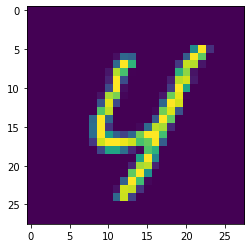

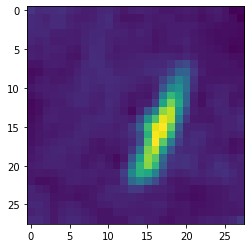

epoch: 1, step: 0, loss: 0.22850152850151062
epoch: 1, step: 200, loss: 0.2116793394088745
epoch: 1, step: 400, loss: 0.20561501383781433


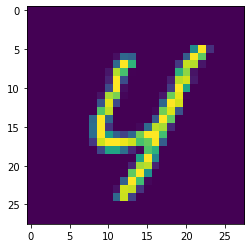

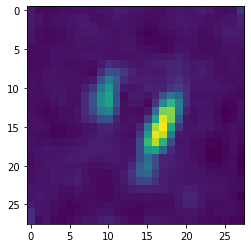

epoch: 2, step: 0, loss: 0.20826628804206848
epoch: 2, step: 200, loss: 0.19676566123962402
epoch: 2, step: 400, loss: 0.18323634564876556


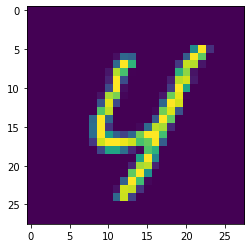

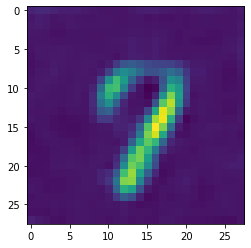

epoch: 3, step: 0, loss: 0.18504975736141205
epoch: 3, step: 200, loss: 0.18773327767848969
epoch: 3, step: 400, loss: 0.1851045936346054


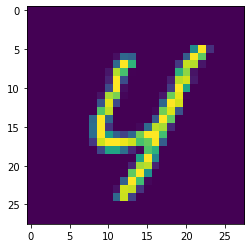

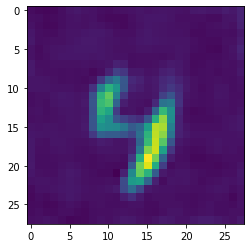

epoch: 4, step: 0, loss: 0.19123618304729462
epoch: 4, step: 200, loss: 0.17548631131649017
epoch: 4, step: 400, loss: 0.18331553041934967


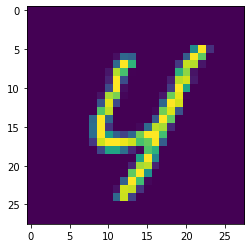

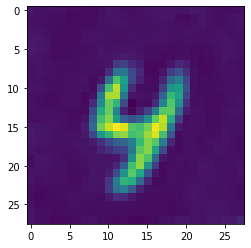

epoch: 5, step: 0, loss: 0.17755581438541412
epoch: 5, step: 200, loss: 0.1781412661075592
epoch: 5, step: 400, loss: 0.17537951469421387


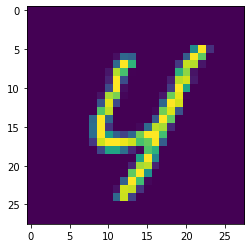

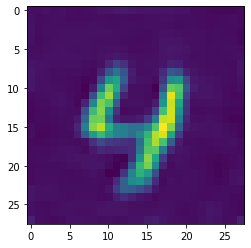

epoch: 6, step: 0, loss: 0.16926589608192444
epoch: 6, step: 200, loss: 0.17017482221126556
epoch: 6, step: 400, loss: 0.16923335194587708


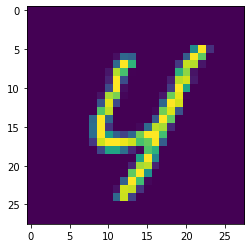

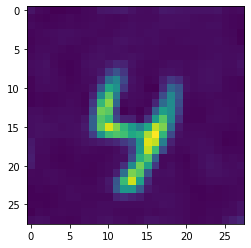

epoch: 7, step: 0, loss: 0.176311194896698
epoch: 7, step: 200, loss: 0.16997453570365906
epoch: 7, step: 400, loss: 0.16989189386367798


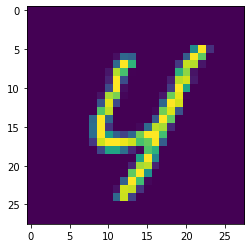

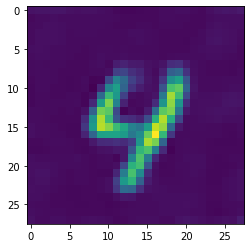

In [11]:
for epoch in range(n_epochs):
    for i, batch in enumerate(trainloader):
        inputs, labels = batch
        optim.zero_grad()

        predict = model(inputs.to(device))
        loss = loss_func(inputs.to(device), predict)
        loss.backward()
        optim.step()
        if i % 200 == 0:
            print(f'epoch: {epoch}, step: {i}, loss: {loss.item()}')
    item = dataset_test[555][0].unsqueeze(0).to(device).float()
    plt.imshow(dataset_test[555][0].squeeze().detach().numpy())
    plt.show()
    plt.imshow(model(item).squeeze().squeeze().cpu().detach().numpy())
    plt.show()
    torch.save(model.state_dict(), f'./lin_ae_chkpt_{epoch}.pth')

epoch: 0, step: 0, loss: 0.966529905796051
epoch: 0, step: 200, loss: 0.2779667377471924
epoch: 0, step: 400, loss: 0.24661248922348022


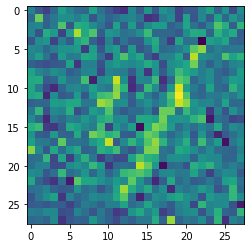

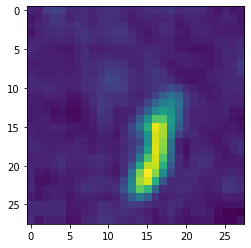

epoch: 1, step: 0, loss: 0.24518047273159027
epoch: 1, step: 200, loss: 0.21433117985725403
epoch: 1, step: 400, loss: 0.21239230036735535


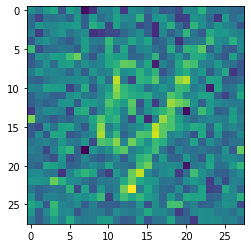

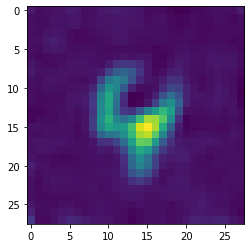

epoch: 2, step: 0, loss: 0.21608379483222961
epoch: 2, step: 200, loss: 0.21592020988464355
epoch: 2, step: 400, loss: 0.19975537061691284


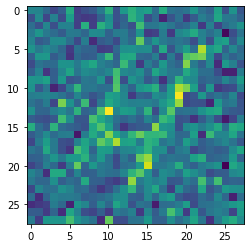

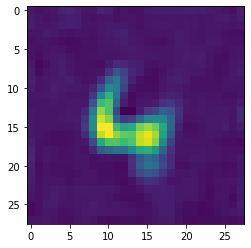

epoch: 3, step: 0, loss: 0.19825269281864166
epoch: 3, step: 200, loss: 0.20825615525245667
epoch: 3, step: 400, loss: 0.19760583341121674


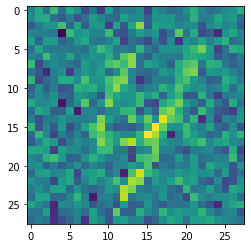

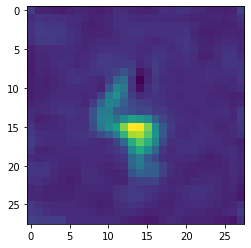

epoch: 4, step: 0, loss: 0.19211351871490479
epoch: 4, step: 200, loss: 0.19980739057064056
epoch: 4, step: 400, loss: 0.19179417192935944


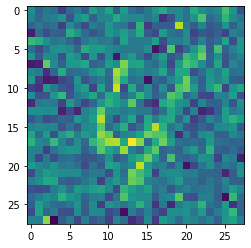

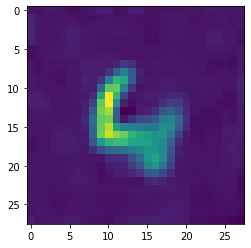

epoch: 5, step: 0, loss: 0.1912107765674591
epoch: 5, step: 200, loss: 0.19234859943389893
epoch: 5, step: 400, loss: 0.18670736253261566


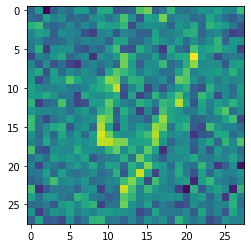

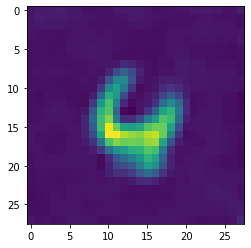

epoch: 6, step: 0, loss: 0.1857493817806244
epoch: 6, step: 200, loss: 0.18997040390968323
epoch: 6, step: 400, loss: 0.1906699687242508


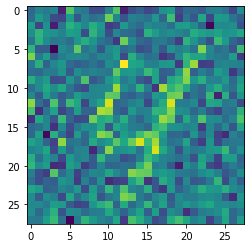

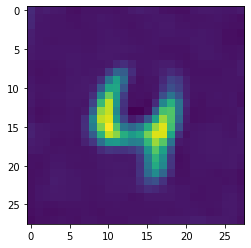

epoch: 7, step: 0, loss: 0.18236611783504486
epoch: 7, step: 200, loss: 0.16908963024616241
epoch: 7, step: 400, loss: 0.18080364167690277


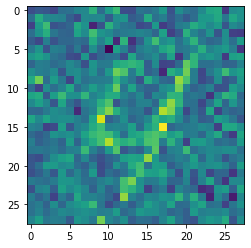

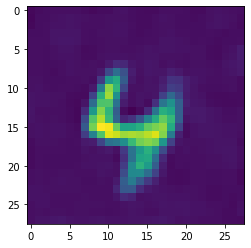

In [12]:
model = ConvAutoEncoder(input_channels, hidden_channels).to(device)
optim = torch.optim.Adam(model.parameters())
loss_func = nn.L1Loss() #TODO try to use MAE

for epoch in range(n_epochs):
    for i, batch in enumerate(trainloader):
        inputs, labels = batch
        optim.zero_grad()
        inputs = inputs.to(device)
        noise_inputs = inputs + \
        torch.normal(torch.zeros_like(inputs), torch.ones_like(inputs)) * 0.8 
        predict = model(noise_inputs)
        loss = loss_func(inputs, predict)
        loss.backward()
        optim.step()
        if i % 200 == 0:
            print(f'epoch: {epoch}, step: {i}, loss: {loss.item()}')
    item = dataset_test[555][0].unsqueeze(0).to(device).float()
    item = item + torch.normal(torch.zeros_like(item), torch.ones_like(item)) * 0.8
    plt.imshow(item.squeeze().squeeze().cpu().detach().numpy())
    plt.show()
    plt.imshow(model(item).squeeze().squeeze().cpu().detach().numpy())
    plt.show()
    torch.save(model.state_dict(), f'./lin_ae_chkpt_{epoch}.pth')

In [9]:
class ConvVAEncoder(nn.Module):
  #28*28 -> hidden -> hidden_out
  def __init__(self, input_ch, hidden_ch):
    super().__init__()
    #TODO try to use other layers
    self.conv1 = nn.Conv2d(input_ch, hidden_ch, kernel_size=5, stride=1, 
                           padding=2) 
    self.do1 = nn.Dropout(0.1)
    self.pool1 = nn.MaxPool2d(2, 2)
    self.conv2 = nn.Conv2d(hidden_ch, hidden_ch, kernel_size=3, stride=1, 
                           padding=1) 
    self.do2 = nn.Dropout(0.1)
    self.pool2 = nn.MaxPool2d(2, 2) 

    self.conv3 = nn.Conv2d(hidden_ch, hidden_ch, kernel_size=3, stride=2, 
                         padding=1) 
    
    self.conv4 = nn.Conv2d(hidden_ch, hidden_ch, kernel_size=3, stride=1, 
                         padding=1)
    self.do4 = nn.Dropout(0.1)
    self.pool4 = nn.MaxPool2d((2, 2)) 

    self.conv5_mu = nn.Conv2d(hidden_ch, 1, kernel_size=3, stride=1, 
                           padding=1) 
    self.conv5_sigma = nn.Conv2d(hidden_ch, 1, kernel_size=3, stride=1, 
                           padding=1) 
    self.activ = nn.ReLU()

  def forward(self, x):
    x = self.pool1(self.do1(self.activ(self.conv1(x))))
    x = self.pool2(self.do2(self.activ(self.conv2(x))))
    x = self.activ(self.conv3(x))
    x = self.pool4(self.do4(self.activ(self.conv4(x))))
    mu = self.conv5_mu(x)
    sigma = torch.exp(self.conv5_sigma(x))

    return mu, sigma

class ConvDecoder(nn.Module):
  #hidden_out-> hidden -> 28*28 
  def __init__(self, input_ch, hidden_ch, ):
    super().__init__()
    #TODO try to use other layers
    self.conv1 = nn.Conv2d(1, hidden_ch, kernel_size=3, stride=1, 
                           padding=1) 
    self.do1 = nn.Dropout(0.1)
    self.upsample1 = nn.UpsamplingNearest2d(scale_factor=2) 

    self.conv2 = nn.ConvTranspose2d(hidden_ch, hidden_ch, kernel_size=3, stride=2, 
                           padding=1) 
    self.do2 = nn.Dropout(0.1)
    self.upsample2 = nn.UpsamplingNearest2d(scale_factor=2) 
    
    self.conv3 = nn.Conv2d(hidden_ch, hidden_ch, kernel_size=3, stride=1, 
                           padding=1)   
    self.conv4 = nn.Conv2d(hidden_ch, hidden_ch, kernel_size=3, stride=1, 
                           padding=1)
    self.do4 = nn.Dropout(0.1)
    self.upsample4 = nn.UpsamplingNearest2d(scale_factor=2) 

    self.conv5 = nn.Conv2d(hidden_ch, input_ch, kernel_size=5, stride=1, 
                           padding=2)
    
    
    self.activ = nn.ReLU()

  def forward(self, x):
    x = self.upsample1(self.do1(self.activ(self.conv1(x))))
    x = self.upsample2(self.do2(self.activ(self.conv2(x))))
    x = self.activ(self.conv3(x))
    x = self.upsample4(self.do2(self.activ(self.conv4(x))))

    return self.conv5(x)

def sampling(mu, sigma):
    return torch.normal(torch.zeros_like(mu), torch.ones_like(mu)) * sigma + mu

class ConvVAE(nn.Module):
  def __init__(self, input_ch, hidden_ch, ):
    super().__init__()
    self.encoder = ConvVAEncoder(input_ch, hidden_ch, )
    self.decoder = ConvDecoder(input_ch, hidden_ch, )

  def forward(self, x):
    mu, sigma = self.encoder(x)
    hidden = sampling(mu, sigma)
    x_ = self.decoder(hidden)

    return x_, mu, sigma

epoch: 0, step: 0, loss: 0.9556065201759338
epoch: 0, step: 200, loss: 0.2719407379627228
epoch: 0, step: 400, loss: 0.24899336695671082


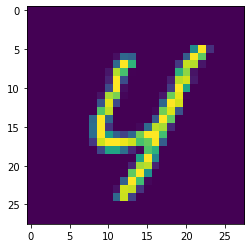

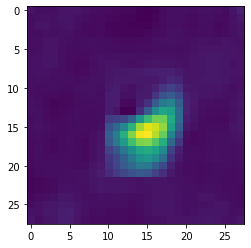

epoch: 1, step: 0, loss: 0.23712801933288574
epoch: 1, step: 200, loss: 0.22246156632900238
epoch: 1, step: 400, loss: 0.20243655145168304


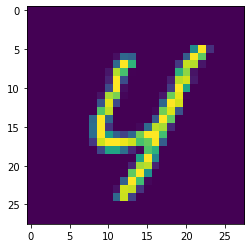

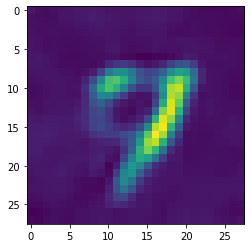

epoch: 2, step: 0, loss: 0.20348089933395386
epoch: 2, step: 200, loss: 0.19021117687225342
epoch: 2, step: 400, loss: 0.18949471414089203


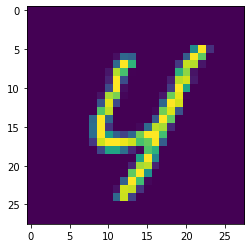

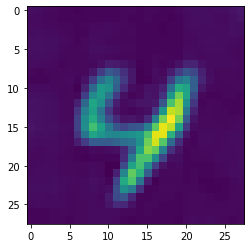

epoch: 3, step: 0, loss: 0.19128558039665222
epoch: 3, step: 200, loss: 0.19120989739894867
epoch: 3, step: 400, loss: 0.17911097407341003


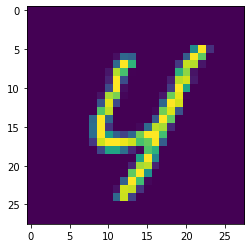

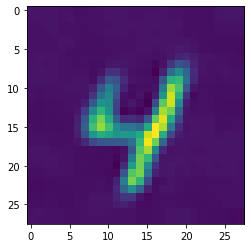

epoch: 4, step: 0, loss: 0.1947157382965088
epoch: 4, step: 200, loss: 0.18490652740001678
epoch: 4, step: 400, loss: 0.18075868487358093


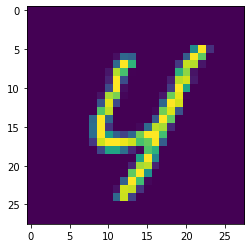

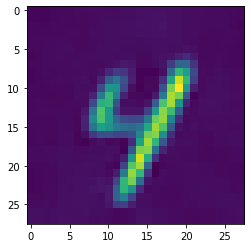

epoch: 5, step: 0, loss: 0.1763623207807541
epoch: 5, step: 200, loss: 0.18522682785987854
epoch: 5, step: 400, loss: 0.18256202340126038


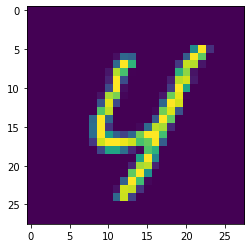

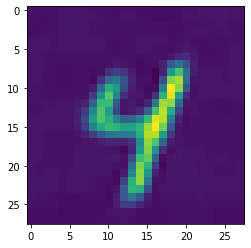

epoch: 6, step: 0, loss: 0.17741873860359192
epoch: 6, step: 200, loss: 0.18084272742271423
epoch: 6, step: 400, loss: 0.17286378145217896


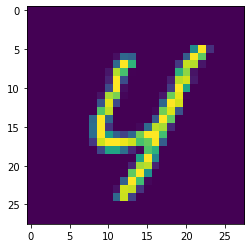

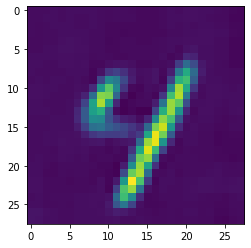

epoch: 7, step: 0, loss: 0.17464053630828857
epoch: 7, step: 200, loss: 0.16761742532253265
epoch: 7, step: 400, loss: 0.17174185812473297


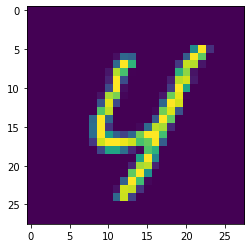

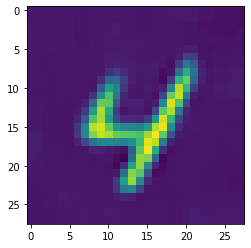

In [10]:
def kl_loss(mu, sigma):
    p = torch.distributions.Normal(mu, sigma)
    q = torch.distributions.Normal(torch.zeros_like(mu), torch.ones_like(mu))
    return torch.distributions.kl_divergence(p, q).mean()

model = ConvVAE(input_channels, hidden_channels).to(device)
optim = torch.optim.Adam(model.parameters())
loss_func = nn.L1Loss() #TODO try to use MAE

for epoch in range(n_epochs):
    for i, batch in enumerate(trainloader):
        inputs, labels = batch
        optim.zero_grad()
        inputs = inputs.to(device)
        # noise_inputs = inputs + \
        # torch.normal(torch.zeros_like(inputs), torch.ones_like(inputs)) * 0.7 
        predict, mu, sigma = model(inputs)
        loss = loss_func(inputs, predict) + 0.01 * kl_loss(mu, sigma)
        loss.backward()
        optim.step()
        if i % 200 == 0:
            print(f'epoch: {epoch}, step: {i}, loss: {loss.item()}')
    item = dataset_test[555][0].unsqueeze(0).to(device).float()
    # item = item + torch.normal(torch.zeros_like(item), torch.ones_like(item)) * 0.7
    plt.imshow(item.squeeze().squeeze().cpu().detach().numpy())
    plt.show()
    plt.imshow(model(item)[0].squeeze().squeeze().cpu().detach().numpy())
    plt.show()
    torch.save(model.state_dict(), f'./lin_ae_chkpt_{epoch}.pth')

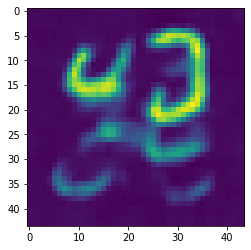

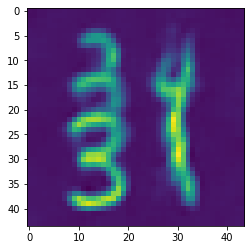

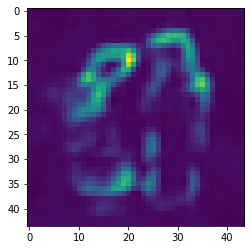

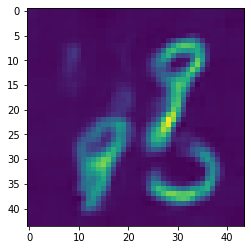

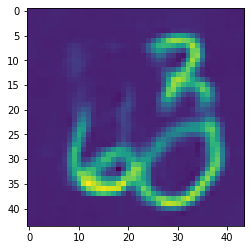

In [14]:
item = dataset_test[555][0].unsqueeze(0).to(device).float()
mu, sigma = model.encoder(item)

for _ in range(5):
    hid = torch.normal(torch.zeros((1,1,3,3)), torch.ones((1,1,3,3))).to(device) 

    plt.imshow(model.decoder(hid).squeeze().squeeze().cpu().detach().numpy())
    plt.show()

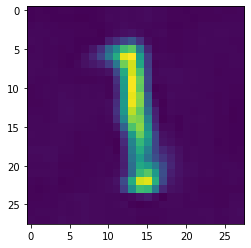

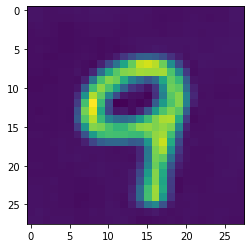

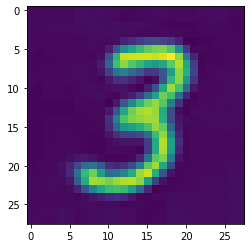

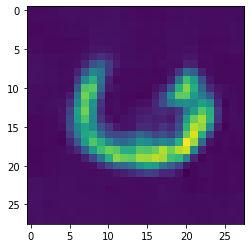

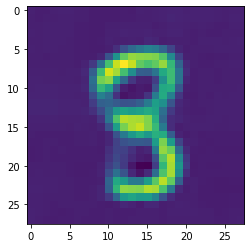

In [15]:
item = dataset_test[555][0].unsqueeze(0).to(device).float()
mu, sigma = model.encoder(item)

for _ in range(5):
    hid = torch.normal(torch.zeros((1,1,2,2)), torch.ones((1,1,2,2))).to(device) 

    plt.imshow(model.decoder(hid).squeeze().squeeze().cpu().detach().numpy())
    plt.show()